In [1]:
import random
import re

from default import PROJECT_HOME
%cd {PROJECT_HOME}

/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire


In [2]:
from dataset.structural.analysis import LinearAnalysis
from dataset.structural.structure import PrattTruss
from dataset.generator import PrattTrussGenerator
from dataset import FixedPrattTrussDataset, FixedPrattTrussDatasetSingleTarget, FixedPrattTrussDatasetThreeTargets
from display import *
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from typing import Dict, Iterable
import numpy as np

In [3]:
def plot(g, def_scale=5):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    for i, r in enumerate(g):
        if i >= 6:  # Since we have 2x3=6 subplots
            break

        display_structure(ax=axs[i], def_scale=def_scale)

    # After plotting all structures, adjust all axes to have same limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    # Find global min and max across all subplots
    for ax in axs:
        x_limits = ax.get_xlim()
        y_limits = ax.get_ylim()
        x_min = min(x_min, x_limits[0])
        x_max = max(x_max, x_limits[1])
        y_min = min(y_min, y_limits[0])
        y_max = max(y_max, y_limits[1])

    # Make the scale the same in both directions - take the wider range
    total_range = max(x_max - x_min, y_max - y_min)
    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    # Apply the same limits to all subplots
    for ax in axs:
        ax.set_xlim(x_center - total_range / 2, x_center + total_range / 2)
        ax.set_ylim(y_center - total_range / 2, y_center + total_range / 2)

        # Ensure aspect ratio is equal
        ax.set_aspect('equal')

    plt.tight_layout()

In [4]:
def sobol_sample(ranges: Dict | Iterable, size, seed=None):
    sampler = Sobol(d=len(ranges), scramble=True, seed=seed)
    sampling = sampler.random(n=size)

    if isinstance(ranges, dict):
        scaled_sampling = dict()
        for i, k in enumerate(ranges.keys()):
            min_val, max_val = ranges[k]
            scaled_sampling[k] = sampling[:, i] * (max_val - min_val) + min_val
    else:
        scaled_sampling = sampling.copy()
        for i, (min_val, max_val) in enumerate(ranges):
            scaled_sampling[:, i] = sampling[:, i] * (max_val - min_val) + min_val

    return scaled_sampling

# Train set
We will generate sets of multiple size

In [5]:
g = PrattTrussGenerator()

In [7]:
def generate_dataset(size,
                     uniform_ea_ratio, three_ea_ratio, random_ea_ratio,
                     random_load_ratio, shared_load_ratio, filepath,
                     young_range=(150e9, 250e9), area_range=(1e-3, 5e-2), load_range=(-1_000.e3, 0.0),
                     display=True):
    if uniform_ea_ratio + random_ea_ratio + three_ea_ratio != 1.:
        raise ValueError("ea ratios must sum to 1")
    if random_load_ratio + shared_load_ratio != 1.:
        raise ValueError("load ratios must sum to 1")

    def routine(size, params_ranges, default_params=None):
        if default_params is None:
            default_params = {
                'n_panels': 8,
                'length': 60.0,
                'height': 7.5,
                'volumetric_weight': 78.5e3
            }

        samples = sobol_sample(
            ranges=params_ranges,
            size=size,
        )

        results_iterator = []
        for i in range(size):
            params = default_params.copy()
            if 'a' in samples:  # Uniform
                params.update({f"A_{j}": samples['a'][i] for j in range(29)})
                params.update({f"E_{j}": samples['e'][i] for j in range(29)})
            elif 'a_v' in samples:  # Uniform per class
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8)})
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8, 14)})
                params.update({f"A_{j}": samples['a_h'][i] for j in [21, 28]})
                params.update({f"A_{j}": samples['a_v'][i] for j in range(14, 21)})
                params.update({f"A_{j}": samples['a_d'][i] for j in range(22, 28)})

                params.update({f"E_{j}": samples['e_h'][i] for j in range(8)})
                params.update({f"E_{j}": samples['e_h'][i] for j in range(8, 14)})
                params.update({f"E_{j}": samples['e_h'][i] for j in [21, 28]})
                params.update({f"E_{j}": samples['e_v'][i] for j in range(14, 21)})
                params.update({f"E_{j}": samples['e_d'][i] for j in range(22, 28)})
            else:  # Non-uniform
                params.update({f"A_{j}": samples[f'a_{j}'][i] for j in range(29)})
                params.update({f"E_{j}": samples[f'e_{j}'][i] for j in range(29)})

            params.update({f"P_x_{i}": 0. for i in range(16)})
            params.update({f"P_y_{i}": 0. for i in range(16)})

            for j in range(1, 8):
                trigger = True if samples[f'b_P_y_{j}'][i] >= .5 else False
                if trigger:
                    if 'P_y' in samples:  # Uniform load
                        params[f"P_y_{j}"] = samples[f"P_y"][i]
                    else:  # Non-uniform load
                        params[f"P_y_{j}"] = samples[f"P_y_{j}"][i]

            struct = PrattTruss()
            struct.generate_model(params)
            LinearAnalysis().run_analysis()
            results_iterator.append(g.construct_result(params))

        return results_iterator

    results_iterator = []

    size_random_load = int(np.round(size * random_load_ratio, decimals=0))
    # Random loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_random_ea = int(np.round(random_ea_ratio * size_random_load, decimals=0))

    results_iterator += routine(size_random_load_random_ea, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_uniform_ea = int(np.round(uniform_ea_ratio * size_random_load, decimals=0))

    results_iterator += routine(size_random_load_uniform_ea, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_three_ea = int(
        np.round(size_random_load - size_random_load_random_ea - size_random_load_uniform_ea, decimals=0))

    results_iterator += routine(size_random_load_three_ea, params_ranges)

    size_shared_load = size - size_random_load
    # Uniform loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_random_ea = int(np.round(random_ea_ratio * size_shared_load, decimals=0))

    results_iterator += routine(size_shared_load_random_ea, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_uniform_ea = int(np.round(uniform_ea_ratio * size_shared_load, decimals=0))
    results_iterator += routine(size_shared_load_uniform_ea, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_three_ea = int(
        np.round(size_shared_load - size_shared_load_random_ea - size_shared_load_uniform_ea, decimals=0))

    results_iterator += routine(size_shared_load_three_ea, params_ranges)

    random.shuffle(results_iterator)  # mixing up all modes
    if filepath is not None: g.save_from_iterator(results_iterator, filepath, max_size=len(results_iterator))
    if display: display_structure()
    return results_iterator


def routine(size, type='train'):
    print(f"Generating data set of size {size}\n   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=1.0, three_ea_ratio=0., random_ea_ratio=.0,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'data/dataset/pratt_truss_bridge/single_ea/{type}_{size}.hdf5')
    print(f"   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=0.3, three_ea_ratio=0.7, random_ea_ratio=.0,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'data/dataset/pratt_truss_bridge/member_ea/{type}_{size}.hdf5')
    print(f"   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=0.3, three_ea_ratio=0.2, random_ea_ratio=.5,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'data/dataset/pratt_truss_bridge/multiple_ea/{type}_{size}.hdf5')

Generating data set of size 128
   

/Users/aflamant/miniconda3/envs/x86Memoire/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_128.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/train_128.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_128.hdf5
Generating data set of size 256
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_256.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/train_256.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_256.hdf5
Generating data set of size 512
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_512.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/train_512.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_512.hdf5
Generating data set of size 1024
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_1024.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/train_1024.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge

/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire/display/osp_display.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_16384.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/train_16384.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_16384.hdf5
Generating data set of size 8192
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/validation_8192.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/validation_8192.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/validation_8192.hdf5
Generating data set of size 8192
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/test_8192.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/member_ea/test_8192.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/test_8192.hdf5


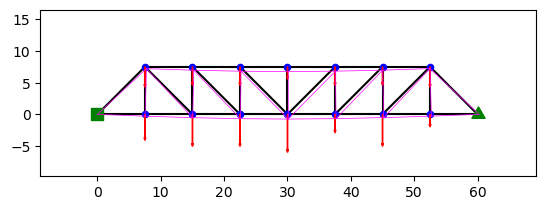

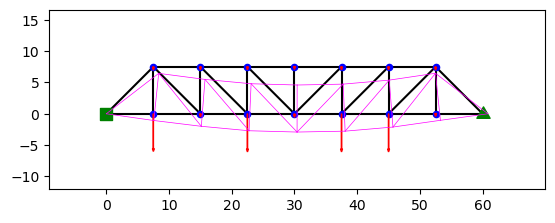

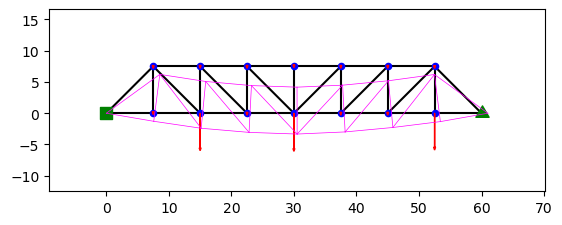

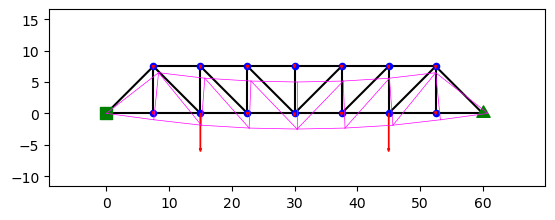

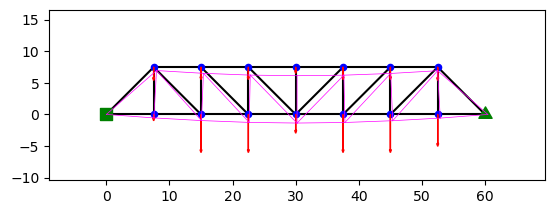

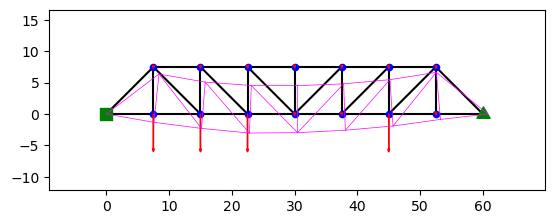

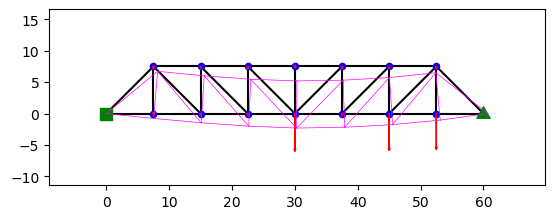

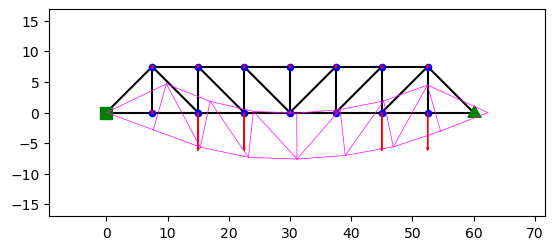

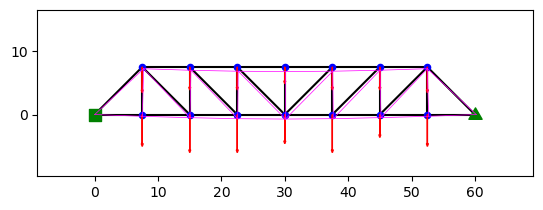

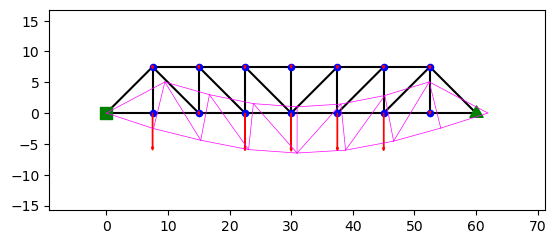

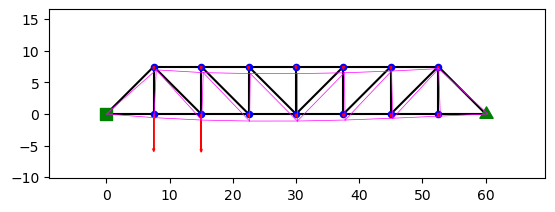

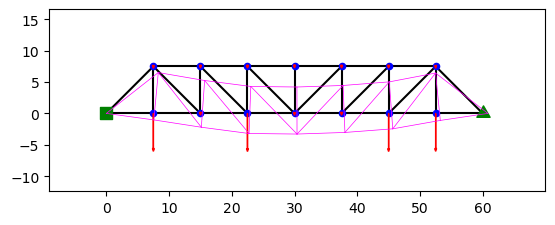

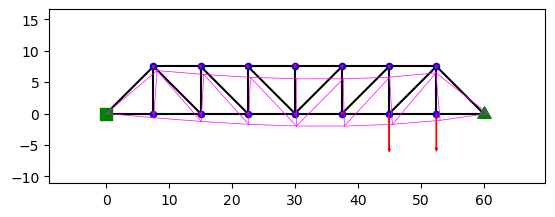

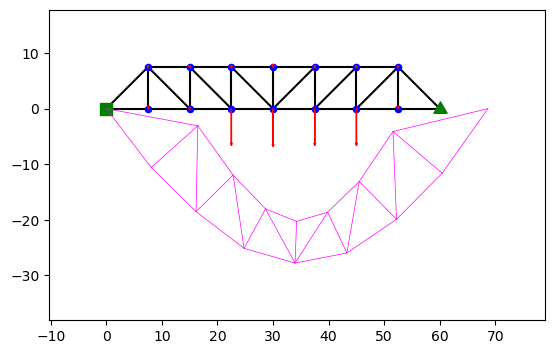

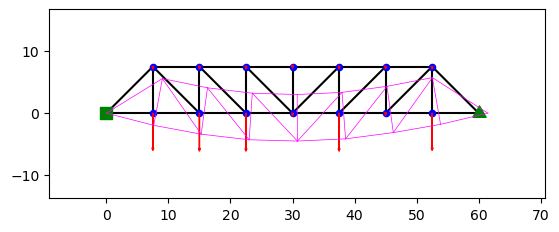

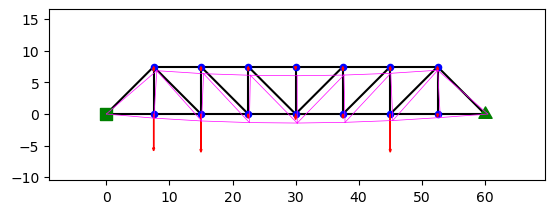

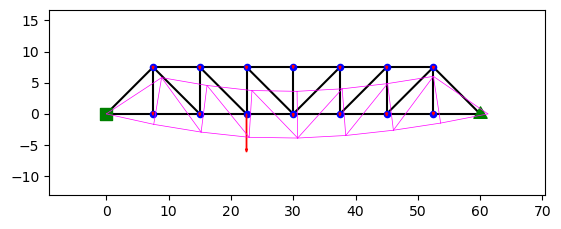

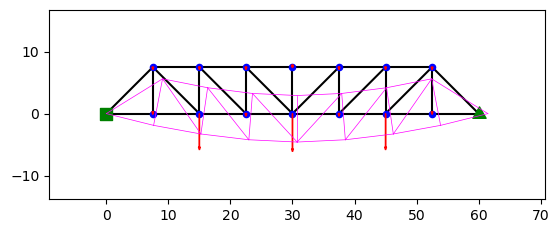

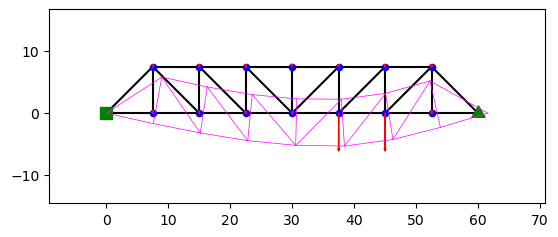

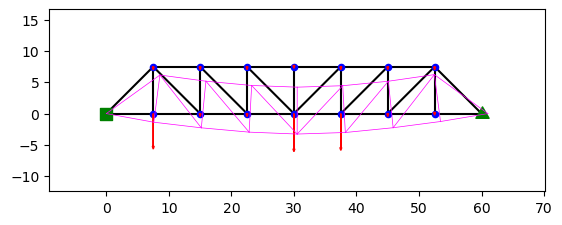

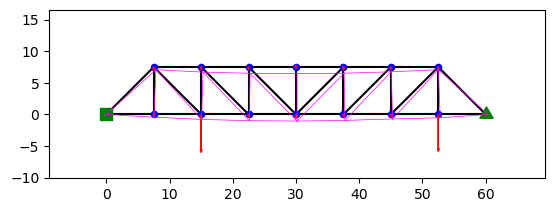

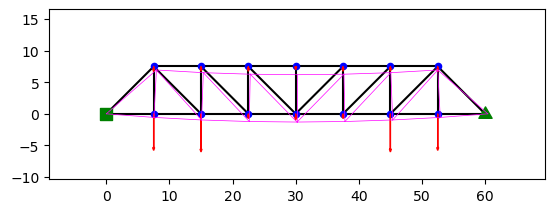

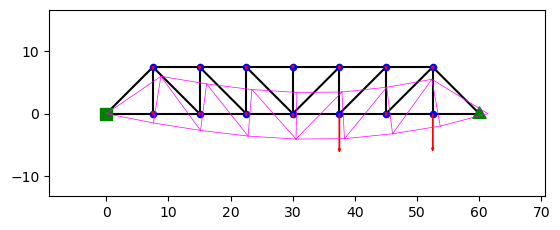

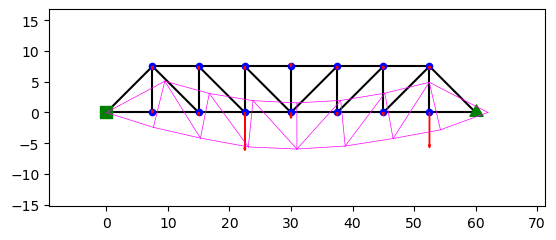

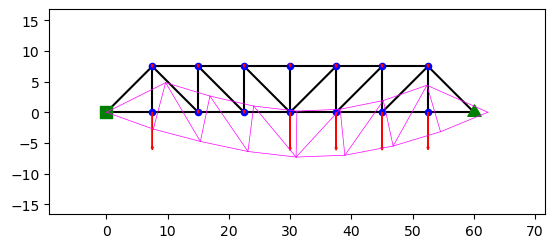

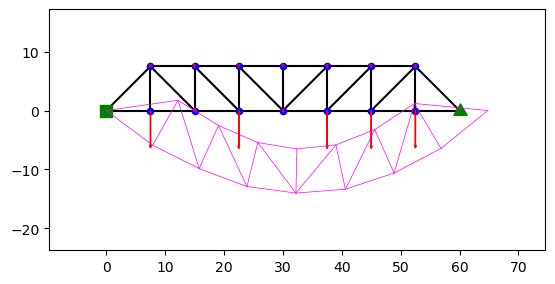

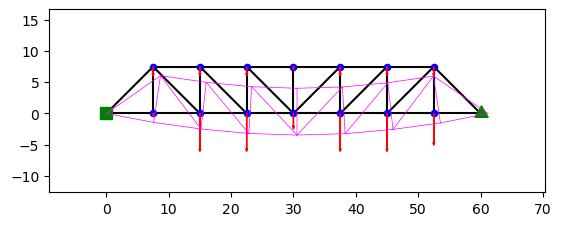

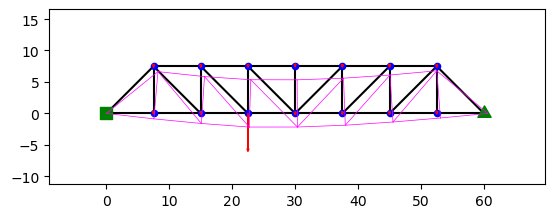

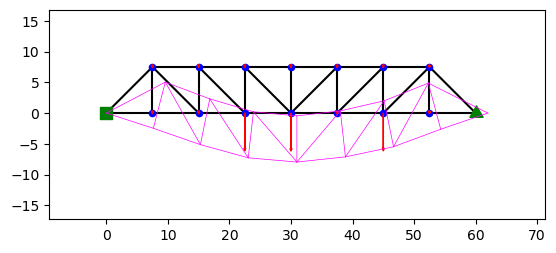

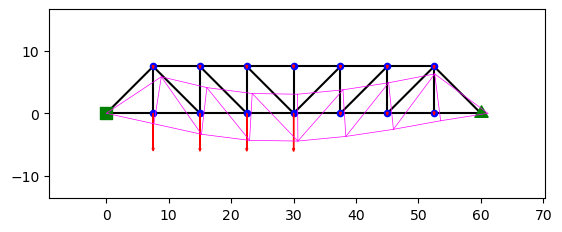

In [8]:
for size in [2 ** i for i in range(7, 15)]: routine(size)
routine(2 ** 13, type='validation')
routine(2 ** 13, type='test')

In [12]:
ds = FixedPrattTrussDatasetSingleTarget("data/dataset/pratt_truss_bridge/single_ea/train_128.hdf5")
ds.load

array([[     0.        ,      0.        ,      0.        , ...,
        -38948.05429533,      0.        , -42602.79643438],
       [     0.        ,      0.        ,      0.        , ...,
        -42353.73176139,      0.        , -46328.05014558],
       [     0.        ,      0.        ,      0.        , ...,
        -50214.10400115,      0.        , -54926.01080081],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
        -33343.02031236,      0.        , -36471.80668138],
       [     0.        ,      0.        ,      0.        , ...,
         -6305.01876167,      0.        ,  -6896.65852835],
       [     0.        ,      0.        ,      0.        , ...,
        -34377.49663034,      0.        , -37603.35445156]])